In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

## import raw data

In [70]:
df = pd.read_excel('../database/export_binance/df_new.xlsx', index_col=0)
df.head(3)

,User_ID,UTC_Time,Account,Operation,Coin,Change,Remark
1,1,2021-05-31 09:00:00,Spot,Deposit,SOL,25.0,NaN
1,1,2021-05-31 09:00:00,Spot,Deposit,BTC,1.0,NaN
1,1,2021-05-31 09:00:00,Spot,Deposit,BNB,35.0,NaN


## spot wallet

### wallet balance overview

In [71]:
#spot balance per coin, enhanced with a current price in USDT
df_spot = df.loc[df['Account'] == 'Spot']
balance_spot = df_spot.groupby('Coin').sum()['Change']
df_current_prices = pd.read_excel('../database/prices/current_prices.xlsx', index_col=0)
holding_prices = []
for i in balance_spot.index:
    if i == 'USDT':
        holding_prices.append(1)
    else:
        try:
            price = df_current_prices.loc[df_current_prices['symbol'] == (i + 'USDT')]['price'].values[0]
            holding_prices.append(price)
        except:
            holding_prices.append(np.nan)
balance_spot = pd.DataFrame(balance_spot)
balance_spot['USDT_price'] = holding_prices
balance_spot['USDT_value'] = holding_prices * balance_spot['Change']
print(f'current total value: {round(balance_spot["USDT_value"].sum(), 2)} USDT')
balance_spot.sort_values(by='USDT_value', ascending=False, inplace=True)
balance_spot.head(3)

current total value: 82620.71 USDT


,Change,USDT_price,USDT_value
Coin,,,
BTC,1.372650,30153.4700,41390.155469
BUSD,21403.548085,1.0007,21418.530568
USDT,4416.448950,1.0000,4416.448950


### monthly spot balance in usdt

In [72]:
#get monthly final balance per coin
df_spot['year_month'] = df_spot['UTC_Time'].dt.strftime('%Y-%m')
monthly_bal = df_spot.groupby(['year_month', 'Coin']).sum()['Change'].reset_index()
monthly_bal = monthly_bal.pivot(index='year_month', columns='Coin', values='Change').fillna(0)
monthly_bal = monthly_bal.cumsum()
print(monthly_bal.shape)
monthly_bal.head(3)

(13, 34)


Coin,AAVE,ADA,ATOM,AUDIO,AVAX,BETA,BNB,BTC,BUSD,CAKE,...,QUICK,RUNE,SAND,SOL,SUSHI,UNI,USDC,USDT,WETH,XTZ
year_month,,,,,,,,,,,,,,,,,,,,,
2021-05,0.0,0.0,0.0,0.0,0.0,0.0,35.000000,1.0,50000.000000,0.0,...,0.0,0.0,0.0,25.0,0.0,0.0,0.0,50000.000000,0.0,0.0
2021-06,0.0,0.0,0.0,0.0,0.0,0.0,35.000000,1.0,47737.536230,0.0,...,0.0,0.0,0.0,25.0,0.0,0.0,0.0,50000.000000,0.0,0.0
2021-07,0.0,0.0,0.0,0.0,80.0,0.0,34.983434,1.0,47224.984639,0.0,...,0.0,0.0,0.0,25.0,0.0,0.0,0.0,44980.921814,0.0,0.0


In [73]:
#import month-end prices for all coins in USDT
df_hist_prices = pd.read_excel('../database/prices/historical_prices.xlsx')
df_hist_prices.set_index('datetime', inplace=True)
print(df_hist_prices.shape)

end_dates = []
for i in monthly_bal.index:
    if i.split('-')[1] == '02':
        end_dates.append(i + '-28')
    elif i.split('-')[1] == '01' or i.split('-')[1] == '03' or i.split('-')[1] == '05' or i.split('-')[1] == '07' or i.split('-')[1] == '08' or i.split('-')[1] == '10' or i.split('-')[1] == '12':
        end_dates.append(i + '-31')
    else:
        end_dates.append(i + '-30')
monthly_prices = df_hist_prices.loc[end_dates].reset_index()
monthly_prices['datetime'] = monthly_prices['datetime'].dt.strftime('%Y-%m')
monthly_prices.set_index('datetime', inplace=True)
monthly_prices.head(3)

(516, 33)


,SOLUSDT,BTCUSDT,BNBUSDT,BUSDUSDT,LTCUSDT,EURUSDT,LINKUSDT,AVAXUSDT,MATICUSDT,SUSHIUSDT,...,CAKEUSDT,DOTUSDT,BETAUSDT,WETHUSDT,FTTUSDT,CELRUSDT,RUNEUSDT,EDGUSDT,USDCUSDT,NEARUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2021-05,32.750,37253.81,353.33,0.9997,187.97,1.2228,32.098,18.140,1.87126,12.474,...,17.926,23.264,0.0,2706.15,34.026,0.04622,12.631,0,0.9999,3.3548
2021-06,35.510,35045.00,303.71,0.9998,144.26,1.1856,19.516,11.949,1.16878,8.158,...,13.836,16.402,0.0,2275.68,27.481,0.02937,6.770,0,0.9999,2.0907
2021-07,36.744,41461.83,332.38,0.9994,144.37,1.1756,22.713,13.525,1.08246,8.863,...,15.957,16.784,0.0,2531.05,35.148,0.03280,6.487,0,0.9994,2.4003


In [75]:
join = monthly_bal.join(monthly_prices, how='outer')
for i in monthly_bal.columns:
    if i == 'USDT':
        pass
    else:
        name_price = i + 'USDT'
        join[i] = join[i] * join[name_price]
join.drop(monthly_prices.columns, axis=1, inplace=True)
join['total_value'] = join.sum(axis=1)
print(join.shape)
join.head(3)

(13, 35)


,AAVE,ADA,ATOM,AUDIO,AVAX,BETA,BNB,BTC,BUSD,CAKE,...,RUNE,SAND,SOL,SUSHI,UNI,USDC,USDT,WETH,XTZ,total_value
year_month,,,,,,,,,,,,,,,,,,,,,
2021-05,0.0,0.0,0.0,0.0,0.0,0.0,12366.550000,37253.81,49985.000000,0.0,...,0.0,0.0,818.75,0.0,0.0,0.0,50000.000000,0.0,0.0,150424.110000
2021-06,0.0,0.0,0.0,0.0,0.0,0.0,10629.850000,35045.00,47727.988723,0.0,...,0.0,0.0,887.75,0.0,0.0,0.0,50000.000000,0.0,0.0,146074.102512
2021-07,0.0,0.0,0.0,0.0,1082.0,0.0,11627.793687,41461.83,47196.649648,0.0,...,0.0,0.0,918.60,0.0,0.0,0.0,44980.921814,0.0,0.0,154552.904033


### monthly funding balance in USDT

In [76]:
investmenst = df_spot.loc[(df_spot['Operation'] == 'Deposit') | (df_spot['Operation'] == 'Withdraw') | (df_spot['Operation'] == 'transfer_in') | (df_spot['Operation'] == 'transfer_out')]
inv_monthly_bal = investmenst.groupby(['year_month', 'Coin']).sum()['Change'].reset_index()
inv_monthly_bal = inv_monthly_bal.pivot(index='year_month', columns='Coin', values='Change').fillna(0)
#inv_monthly_bal = inv_monthly_bal.cumsum()
print(inv_monthly_bal.shape)
inv_monthly_bal.head(3)

(10, 12)


Coin,AVAX,BNB,BTC,BUSD,CAKE,ETH,EUR,FTM,SOL,USDC,USDT,WETH
year_month,,,,,,,,,,,,
2021-05,0.0,35.00,1.0,50000.0,0.00000,0.0,0.00,0.0,25.0,0.0,50000.0,0.0
2021-08,0.0,0.00,0.0,0.0,0.00000,0.0,-638.77,0.0,0.0,0.0,0.0,0.0
2021-09,0.0,-0.05,0.0,0.0,454.66115,0.0,-1000.00,0.0,0.0,0.0,-6216.0,0.0


In [82]:
col = []
for i in inv_monthly_bal.columns.drop('USDT'):
    name_price = i + 'USDT'
    col.append(name_price)
    
end_dates = []
for i in inv_monthly_bal.index:
    if i.split('-')[1] == '02':
        end_dates.append(i + '-28')
    elif i.split('-')[1] == '01' or i.split('-')[1] == '03' or i.split('-')[1] == '05' or i.split('-')[1] == '07' or i.split('-')[1] == '08' or i.split('-')[1] == '10' or i.split('-')[1] == '12':
        end_dates.append(i + '-31')
    else:
        end_dates.append(i + '-30')
inv_monthly_prices = df_hist_prices.loc[end_dates].reset_index()
inv_monthly_prices['datetime'] = inv_monthly_prices['datetime'].dt.strftime('%Y-%m')
inv_monthly_prices.set_index('datetime', inplace=True)
inv_monthly_prices = inv_monthly_prices.loc[:,col]
print(inv_monthly_prices.shape)
inv_monthly_prices.head(3)

(10, 11)


,AVAXUSDT,BNBUSDT,BTCUSDT,BUSDUSDT,CAKEUSDT,ETHUSDT,EURUSDT,FTMUSDT,SOLUSDT,USDCUSDT,WETHUSDT
datetime,,,,,,,,,,,
2021-05,18.14,353.33,37253.81,0.9997,17.926,2706.15,1.2228,0.3207,32.75,0.9999,2706.15
2021-08,39.50,463.90,47100.89,0.9997,22.890,3429.20,1.1690,0.7200,108.27,0.9997,3429.20
2021-09,66.63,387.50,43824.10,0.9999,18.910,3000.61,1.1570,1.2064,141.37,1.0001,3000.61


In [83]:
join_inv = inv_monthly_bal.join(inv_monthly_prices, how='outer')
for i in inv_monthly_bal.columns:
    if i == 'USDT':
        pass
    else:
        name_price = i + 'USDT'
        join_inv[i] = join_inv[i] * join_inv[name_price]
join_inv.drop(inv_monthly_prices.columns, axis=1, inplace=True)
join_inv['total_value'] = join_inv.sum(axis=1)
join_inv['total_value'] = join_inv['total_value'].cumsum()
print(join_inv.shape)
join_inv.head(3)

(10, 13)


,AVAX,BNB,BTC,BUSD,CAKE,ETH,EUR,FTM,SOL,USDC,USDT,WETH,total_value
year_month,,,,,,,,,,,,,
2021-05,0.0,12366.550,37253.81,49985.0,0.00000,0.0,0.00000,0.0,818.75,0.0,50000.0,0.0,150424.11000
2021-08,0.0,0.000,0.00,0.0,0.00000,0.0,-746.72213,0.0,0.00,0.0,0.0,0.0,149677.38787
2021-09,0.0,-19.375,0.00,0.0,8597.64235,0.0,-1157.00000,0.0,0.00,0.0,-6216.0,0.0,150882.65522


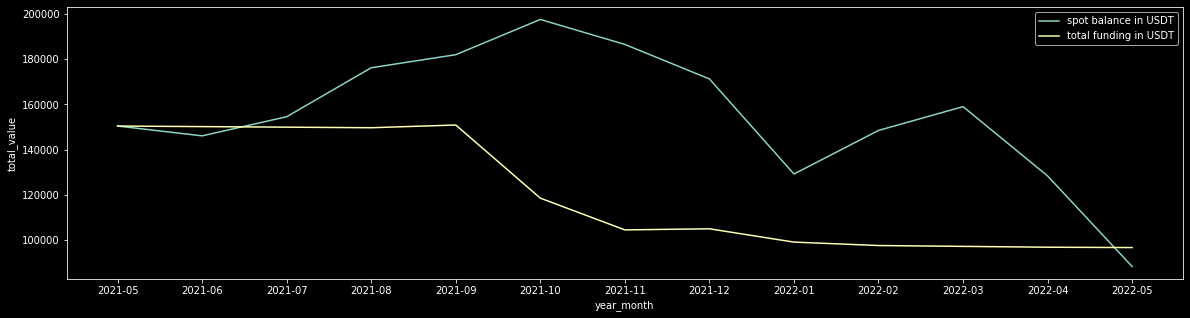

In [88]:
fig = plt.figure(figsize=(20, 5))
sns.lineplot(x=join.index, y='total_value', data=join, label='spot balance in USDT')
sns.lineplot(x=join_inv.index, y='total_value', data=join_inv, label='total funding in USDT');

## trades

### trades per coin plot

In [84]:
#import prices for all coins in USDT
df_hist_prices = pd.read_excel('../database/prices/historical_prices.xlsx')
df_hist_prices.set_index('datetime', inplace=True)
print(df_hist_prices.shape)
df_hist_prices.head(5)

(516, 33)


,SOLUSDT,BTCUSDT,BNBUSDT,BUSDUSDT,LTCUSDT,EURUSDT,LINKUSDT,AVAXUSDT,MATICUSDT,SUSHIUSDT,...,CAKEUSDT,DOTUSDT,BETAUSDT,WETHUSDT,FTTUSDT,CELRUSDT,RUNEUSDT,EDGUSDT,USDCUSDT,NEARUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01,1.8421,29331.69,37.7762,0.9973,126.24,1.2183,11.8477,3.6497,0.01777,3.333,...,0.0,8.2776,0.0,728.91,5.806,0.00479,1.2874,0,0.9974,1.3587
2021-01-02,1.7999,32178.33,38.2331,0.9989,136.96,1.2412,12.2215,3.4956,0.01904,3.203,...,0.0,9.2037,0.0,774.56,6.200,0.00480,1.2919,0,0.9989,1.4124
2021-01-03,2.1779,33000.05,41.2575,0.9979,161.24,1.2594,13.6814,3.4691,0.01997,3.445,...,0.0,10.1307,0.0,978.28,6.945,0.00538,1.4839,0,0.9992,1.4707
2021-01-04,2.4909,31988.71,41.1333,0.9993,155.34,1.2286,13.5935,3.5999,0.02468,3.563,...,0.0,9.5126,0.0,1041.43,7.535,0.00566,1.5929,0,0.9994,1.3868
2021-01-05,2.1636,33949.53,41.8219,0.9969,158.43,1.2274,14.5162,4.2501,0.02440,3.853,...,0.0,9.7084,0.0,1099.56,8.656,0.00592,1.5826,0,0.9969,1.4953


In [85]:
#get trade related operations
trades = df.loc[((df['Operation'] == 'Buy')) | ((df['Operation'] == 'Sell')) | ((df['Operation'] == 'Large OTC trading')) | ((df['Operation'] == 'Small assets exchange BNB')) | ((df['Operation'] == 'Transaction Related'))]
#separate columns for buy and sell and cut time from datetime
trades['buy'] = trades['Change'].apply(lambda x: x if x > 0 else np.nan)
trades['sell'] = trades['Change'].apply(lambda x: x if x < 0 else np.nan)
trades['UTC_Time'] = trades['UTC_Time'].apply(lambda x: x.strftime('%Y-%m-%d'))
trades = trades[['UTC_Time', 'buy', 'sell', 'Coin']].set_index('UTC_Time').sort_values(by=['Coin', 'buy'])
#delete duplicated dates
trades = trades.reset_index().groupby(['UTC_Time', 'Coin']).agg({'buy': 'sum', 'sell': 'sum'}).reset_index().sort_values(by=['Coin', 'UTC_Time'])
trades = trades.replace(0,np.nan)
trades['UTC_Time'] = pd.to_datetime(trades['UTC_Time'])
trades.set_index('UTC_Time', inplace=True)
trades

,Coin,buy,sell
UTC_Time,,,
2021-08-22,AAVE,5.7725,NaN
2021-08-24,AAVE,1.1000,NaN
2021-08-25,AAVE,NaN,-0.772500
2021-09-14,AAVE,NaN,-5.000000
2021-09-16,ADA,640.0000,NaN
...,...,...,...
2022-05-09,USDT,571.2388,NaN
2022-05-11,USDT,148.8300,NaN
2021-10-22,WETH,NaN,-1.164775


In [86]:
#integrate historical prices with trades
for i in trades['Coin'].unique():
    buy_name = i + '_buy'
    sell_name = i + '_sell'
    temp = trades.loc[trades['Coin'] == i]
    temp[buy_name] = temp['buy']
    temp[sell_name] = temp['sell']
    temp.drop(['Coin', 'buy', 'sell'], axis=1, inplace=True)
    df_hist_prices = pd.merge(df_hist_prices, temp, how='outer', left_index=True, right_index=True)
print(df_hist_prices.shape)
df_hist_prices.head(3)

(516, 99)


,SOLUSDT,BTCUSDT,BNBUSDT,BUSDUSDT,LTCUSDT,EURUSDT,LINKUSDT,AVAXUSDT,MATICUSDT,SUSHIUSDT,...,UNI_buy,UNI_sell,USDC_buy,USDC_sell,USDT_buy,USDT_sell,WETH_buy,WETH_sell,XTZ_buy,XTZ_sell
2021-01-01,1.8421,29331.69,37.7762,0.9973,126.24,1.2183,11.8477,3.6497,0.01777,3.333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,1.7999,32178.33,38.2331,0.9989,136.96,1.2412,12.2215,3.4956,0.01904,3.203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,2.1779,33000.05,41.2575,0.9979,161.24,1.2594,13.6814,3.4691,0.01997,3.445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


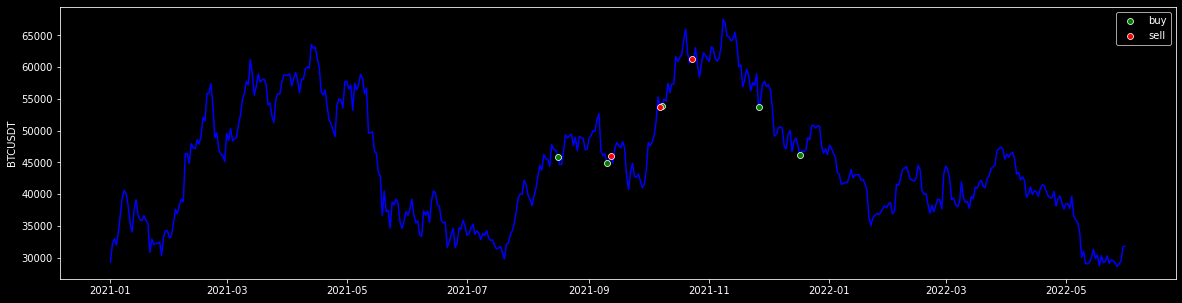

In [87]:
#plot trades and prices (input coin name)
def plot_trades(df, coin):

    price_name = coin + 'USDT'
    buy_name = coin + '_buy'
    sell_name = coin + '_sell'

    temp = df_hist_prices[[price_name, buy_name, sell_name]]
    temp = temp.loc[(temp[buy_name] > 0) | (temp[sell_name] < 0)]

    temp[buy_name] = temp[buy_name].apply(lambda x: 1 if x > 0 else np.nan)
    temp[sell_name] = temp[sell_name].apply(lambda x: 1 if x < 0 else np.nan)
    temp[buy_name] = temp[buy_name] * temp[price_name]
    temp[sell_name] = temp[sell_name] * temp[price_name]

    fig = plt.figure(figsize=(20, 5))
    sns.lineplot(x=df.index, y=price_name, data=df, color='blue')
    sns.lineplot(x=temp.index, y=buy_name, data=temp, color='g', marker='o', label='buy', linestyle='')
    sns.lineplot(x=temp.index, y=sell_name, data=temp, color='r', marker='o', label='sell', linestyle='');
    plt.legend()
    plt.show()
plot_trades(df_hist_prices, input('coin: '))